# Healthy Homes Initial Tract Diagnostics

In this notebook, I show some basic diagnostics using a tract-level dataset merging health, census, and property ownership data. 

## Ownership
For the property ownership data, I calculated some preliminary fields using the 2014 assessor data:

* `numerator`: number of properties owned by parties owning five or more residential properties with structures that are currently taxable
* `denominator`: number of residential properties with structures
* `investor_rate` = `numerator` / `denominator` * 100

__Note: I dropped tracts with `denominator` < 100__

The 2015 assessor data provided by Josh are missing fields indicating presence of structure, so I did not prepare similar fields for that year.

## Tax foreclosure
Using D3's 2002-2013 archival tax foreclosure data, I calculated:

* `fc2012`: 2012 tract count of tax foreclosures
* `fc2013`: 2013 tract count of tax foreclosures
* `fc12rate` and `fc13rate`: tract foreclosure count divided by `denominator` * 100

_I used data from years prior to allow for a time lag effect. We need to be clear about how we theorize the relationship between tax foreclosure, tax foreclosure sales, time and health._

## ACS Data
I pulled the data myself because it was easier for me to put the raw data into a research database with the other data sources. I am including only a few key variables for present. Data from 2014 ACS 5-Year estimates.

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# import merged dataset, prepared elsewhere, as (geo)pandas dataframe 
datasrc = "/home/eric/detroit_research_projects/data/HealthyHomes/merged_data.pickle"
df = pd.read_pickle(datasrc)
df.head()

,pop,under5,pctunder5,pct65plus,pctnhblack,pcthisp,povrate,rentership,pctbefore1960,pct6079,...,chol2014,bp2014,chd2014,asth2014,copd2014,ebll2014,ebll2015,ebll2016,ebll2017,ebll2014rate
26163500100,3310.0,347.0,10.483384,8.036254,88.217523,0.000000,28.821752,46.824225,88.746356,10.437318,...,36.6,40.7,5.9,13.6,8.5,20,10,13,8,57.636888
26163500200,2816.0,162.0,5.752841,9.978693,90.589489,0.000000,36.918080,37.837838,83.588093,15.124698,...,36.9,41.3,6.3,14.0,9.1,9,5,4,3,55.555556
26163500300,2243.0,182.0,8.114133,5.349978,92.019617,0.490415,49.932946,50.061805,87.883683,10.743134,...,37.2,42.5,6.2,14.5,9.7,14,10,15,5,76.923077
26163500400,1019.0,56.0,5.495584,10.598626,80.078508,2.158979,51.815505,49.168646,81.264916,9.904535,...,37.6,43.8,6.4,15.2,10.4,10,1,9,6,178.571429
26163500500,1706.0,86.0,5.041032,8.616647,97.479484,0.527550,28.195938,34.862385,90.870488,7.430998,...,36.2,41.2,6.0,13.7,8.5,6,7,4,2,69.767442


In [3]:
# list columns
df.columns

Index([u'pop', u'under5', u'pctunder5', u'pct65plus', u'pctnhblack',
       u'pcthisp', u'povrate', u'rentership', u'pctbefore1960', u'pct6079',
       u'geometry', u'investor_rate', u'denominator', u'numerator', u'fc2012',
       u'fc2013', u'fc13rate', u'fc12rate', u'obes2014', u'db2014',
       u'chol2014', u'bp2014', u'chd2014', u'asth2014', u'copd2014',
       u'ebll2014', u'ebll2015', u'ebll2016', u'ebll2017', u'ebll2014rate'],
      dtype='object')

In [4]:
# get summary statistics for property variables
property_columns = ['numerator', 'denominator', 'investor_rate', 'fc2012', 'fc2013', 'fc12rate', 'fc13rate']
df[property_columns].describe()

,numerator,denominator,investor_rate,fc2012,fc2013,fc12rate,fc13rate
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,114.449438,881.734082,12.497029,74.490637,69.265918,8.279928,8.654377
std,74.767913,410.063630,4.744692,49.054777,38.430981,3.583257,4.276889
min,6.000000,116.000000,2.965779,1.000000,7.000000,0.471698,1.248266
25%,54.500000,557.500000,9.407113,38.500000,40.000000,5.856156,4.943120
50%,101.000000,846.000000,12.027491,65.000000,63.000000,7.932264,8.649469
75%,156.000000,1227.500000,15.546450,103.500000,92.000000,10.205980,11.603885
max,354.000000,1875.000000,38.345865,260.000000,203.000000,18.687589,30.333333


In [5]:
# get summary statistics for ACS variables
ACS_columns = ['pop', 'pctunder5', 'pct65plus', 'pctnhblack', 'pcthisp', 'povrate', 'rentership', 'pctbefore1960', 'pct6079']
df[ACS_columns].describe()

,pop,pctunder5,pct65plus,pctnhblack,pcthisp,povrate,rentership,pctbefore1960,pct6079
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,2424.737828,7.192882,11.979632,82.780379,6.586547,41.477032,46.922483,83.781439,9.997320
std,1093.208944,3.067208,4.758683,25.160608,17.848094,12.738296,14.313165,10.982151,6.464329
min,478.000000,0.828402,2.173913,0.968280,0.000000,7.265086,10.042433,20.952381,0.000000
25%,1585.500000,4.839011,8.747359,83.529063,0.000000,33.474940,37.746643,79.722461,5.371516
50%,2362.000000,6.979280,11.358025,92.932862,0.446429,41.714781,46.478873,85.842294,8.776596
75%,3180.000000,9.316296,15.188093,96.555846,2.047060,49.499093,54.651822,91.159647,13.544669
max,5990.000000,17.831541,30.583756,99.937265,82.551020,80.929487,89.308176,100.000000,42.219020


In [6]:
# get summary statistics for health variables 2014
HH_columns = ['obes2014', 'db2014', 'chol2014', 'bp2014', 'chd2014', 'asth2014', 'copd2014', 'ebll2014', 'ebll2014rate']
df[HH_columns].describe()

,obes2014,db2014,chol2014,bp2014,chd2014,asth2014,copd2014,ebll2014,ebll2014rate
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,45.540824,18.252434,41.313109,46.998127,8.710861,14.170412,11.308614,9.764045,88.378885
std,3.466513,3.011735,2.244529,5.960903,1.584510,1.240416,2.091974,7.865441,155.430361
min,34.100000,10.900000,36.000000,28.300000,5.600000,10.300000,5.600000,0.000000,0.000000
25%,43.500000,15.900000,39.900000,43.800000,7.500000,13.500000,9.800000,4.000000,25.211864
50%,46.100000,18.600000,41.500000,48.500000,8.700000,14.300000,11.200000,8.000000,49.450549
75%,48.100000,20.500000,42.800000,51.000000,9.900000,15.100000,12.800000,13.500000,90.909091
max,52.700000,26.100000,48.300000,58.900000,14.100000,17.900000,17.300000,40.000000,1750.000000


In [7]:
# Drop outlier
df = df.loc[df['ebll2014rate']<1000]

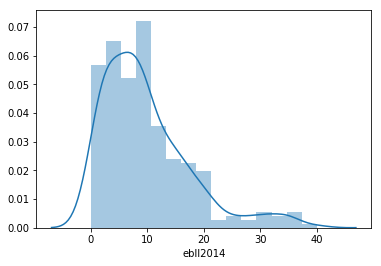

In [8]:
# get hist of EBLL count
sns.distplot(df['ebll2014'])

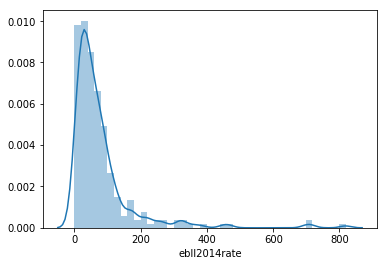

In [9]:
# get hist of EBLL rate
sns.distplot(df['ebll2014rate'])

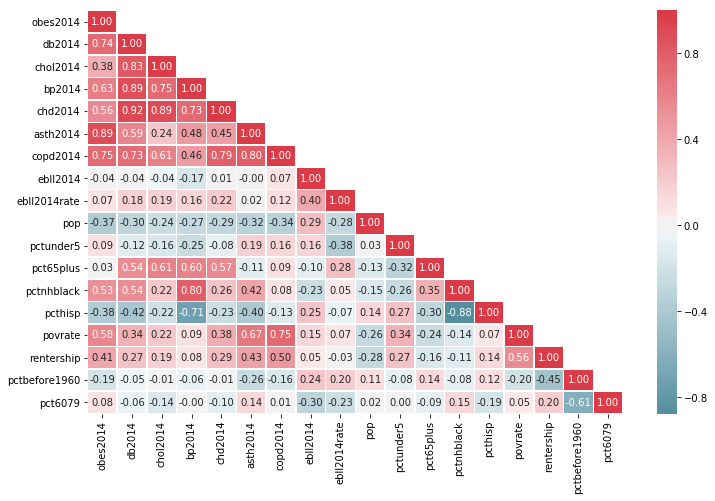

In [10]:
corr = df[HH_columns+ACS_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)  
mask[np.triu_indices_from(mask, k=1)] = True
w = 12
h = .618 * w
fig, ax = plt.subplots(figsize=(w,h))
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, ax=ax, mask=mask, center=0, cmap=cmap, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size":10})

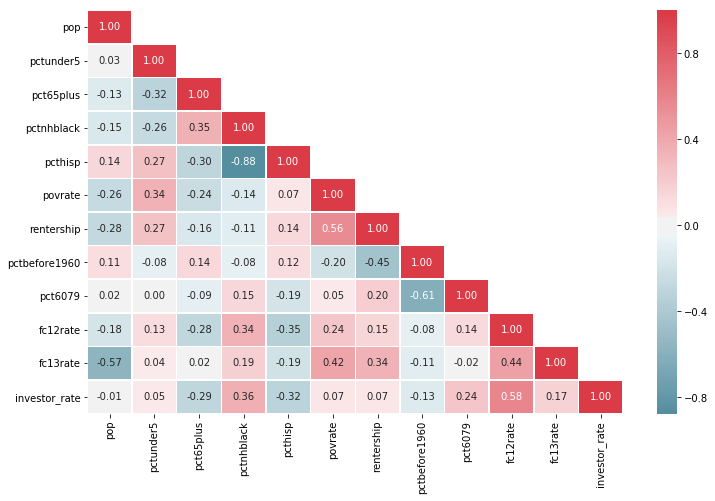

In [11]:
corr = df[ACS_columns+['fc12rate', 'fc13rate', 'investor_rate']].corr()
mask = np.zeros_like(corr, dtype=np.bool)  
mask[np.triu_indices_from(mask, k=1)] = True
w = 12
h = .618 * w
fig, ax = plt.subplots(figsize=(w,h))
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, ax=ax, mask=mask, center=0, cmap=cmap, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size":10})

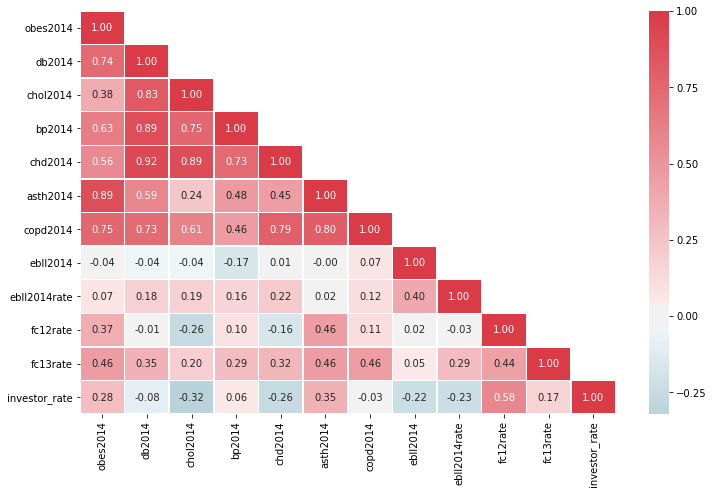

In [12]:
corr = df[HH_columns+['fc12rate', 'fc13rate', 'investor_rate']].corr()
mask = np.zeros_like(corr, dtype=np.bool)  
mask[np.triu_indices_from(mask, k=1)] = True
w = 12
h = .618 * w
fig, ax = plt.subplots(figsize=(w,h))
# # Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, ax=ax, mask=mask, center=0, cmap=cmap, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size":10})

**Initial observations:** Tax foreclosure rate for 2012 and 2013 has a modestly positive relationship with astha, while the 2013 tax foreclosure rate has an association with copd. What other variales might cause a rise in both variables?

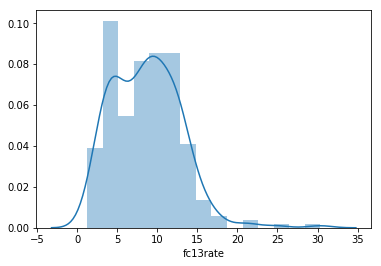

In [13]:
# plot distribution of the tax foreclosure rate
sns.distplot(df['fc13rate'])

## Mapping

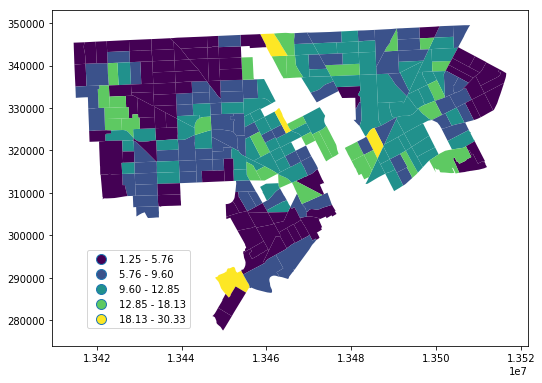

In [14]:
# show tax foreclosure rate
w = 10
h = .618 * w
ax=gpd.plotting.plot_dataframe(df, column='fc13rate', scheme='Fisher_Jenks', legend=True, figsize=(w,h))
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.1, 0.2, 0.2))

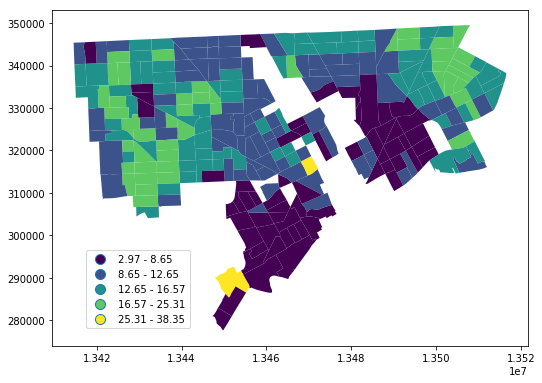

In [15]:
# show property investor rate
ax=gpd.plotting.plot_dataframe(df, column='investor_rate', scheme='Fisher_Jenks', legend=True, figsize=(w,h))
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.1, 0.2, 0.2))

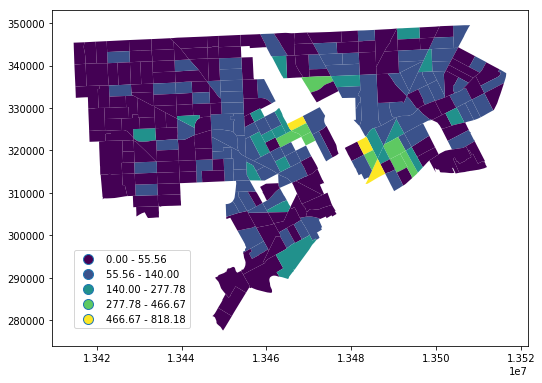

In [16]:
# show ebll rate
ax=gpd.plotting.plot_dataframe(df, column='ebll2014rate', scheme='Fisher_Jenks', legend=True, figsize=(w,h))
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.1, 0.2, 0.2))

## Models

We probably want to use negative binomial for strictly tract-level analysis. That requires numerator and denominator for health rate variables. I will run OLS of asthma on foreclosure rate just for illustration. 

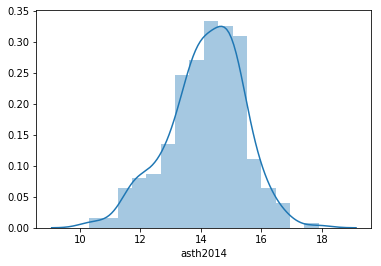

In [17]:
sns.distplot(df['asth2014'])

In [18]:
model1 = smf.ols(formula='asth2014 ~ fc13rate + povrate + pctnhblack + pctbefore1960 + pct6079', data=df)
results = model1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               asth2014   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     134.6
Date:                Tue, 27 Mar 2018   Prob (F-statistic):           6.48e-70
Time:                        11:15:39   Log-Likelihood:                -262.92
No. Observations:                 265   AIC:                             537.8
Df Residuals:                     259   BIC:                             559.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.0635      0.523     19.235

In [19]:
model1 = smf.ols(formula='asth2014 ~ investor_rate + povrate + pctnhblack + pctbefore1960 + pct6079', data=df)
results = model1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               asth2014   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     143.4
Date:                Tue, 27 Mar 2018   Prob (F-statistic):           1.72e-72
Time:                        11:15:39   Log-Likelihood:                -256.83
No. Observations:                 265   AIC:                             525.7
Df Residuals:                     259   BIC:                             547.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.0462      0.511     19.665

In [20]:
# nb on ebll
model1 = smf.negativebinomial(formula='ebll2014 ~ fc13rate + povrate + pctnhblack + pctbefore1960 + pct6079 + rentership', 
                              data=df, offset=np.log(df['under5']))
results = model1.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 3.261269
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
                     NegativeBinomial Regression Results                      
Dep. Variable:               ebll2014   No. Observations:                  265
Model:               NegativeBinomial   Df Residuals:                      258
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                 0.04622
Time:                        11:15:39   Log-Likelihood:                -864.24
converged:                       True   LL-Null:                       -906.12
                                        LLR p-value:                 5.940e-16
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.3470      0.

In [21]:
# sub in investor rate for tax foreclosure rate
model1 = smf.negativebinomial(formula='ebll2014 ~ investor_rate + povrate + pctnhblack + pctbefore1960 + pct6079 + rentership', 
                              data=df, offset=np.log(df['under5']))
results = model1.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 3.279873
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
                     NegativeBinomial Regression Results                      
Dep. Variable:               ebll2014   No. Observations:                  265
Model:               NegativeBinomial   Df Residuals:                      258
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Mar 2018   Pseudo R-squ.:                 0.04078
Time:                        11:15:39   Log-Likelihood:                -869.17
converged:                       True   LL-Null:                       -906.12
                                        LLR p-value:                 6.439e-14
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.3434      0.

Results show positive relationship between 2013 tax foreclosure rate and EBLL2014, but the investor rate has a *negative* relationship with EBLL.